In [3]:
import numpy as np
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, model_from_json, Model
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Dense, Flatten, Dropout
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
%matplotlib inline
from pathlib import Path
import pandas as pd

## Loading dataset

In [4]:
df = pd.read_pickle("data/comb_20201118.pkl")
df.head()

,emotion,pixels
0,0,"[[[4.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0..."
1,1,"[[[77.0], [78.0], [79.0], [79.0], [78.0], [75...."
2,1,"[[[85.0], [84.0], [90.0], [121.0], [101.0], [1..."
3,0,"[[[39.0], [75.0], [78.0], [58.0], [58.0], [45...."
4,0,"[[[219.0], [213.0], [206.0], [202.0], [209.0],..."


In [5]:
df['emotion'].value_counts()
# plotting seaborn

1    9217
0    6538
2     718
Name: emotion, dtype: int64

In [8]:
mpl.rcParams['figure.figsize'] = [9, 7] 

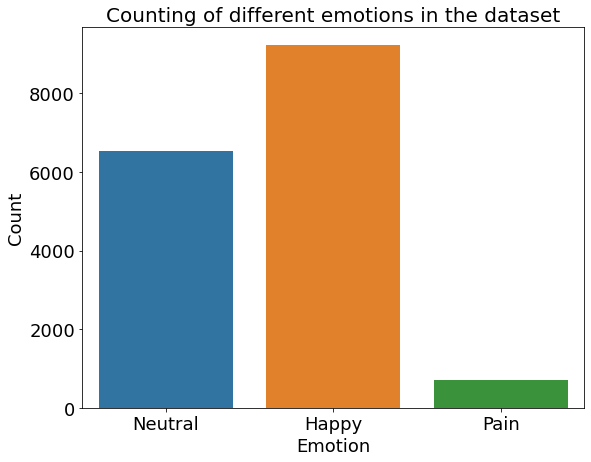

In [10]:
sns.countplot(df['emotion'])
plt.title("Counting of different emotions in the dataset", fontsize=20)
plt.xlabel("Emotion", fontsize=18)
plt.xticks(ticks = range(3), labels=['Neutral', 'Happy', 'Pain'], fontsize=18)
plt.ylabel("Count", fontsize=18)
plt.yticks(fontsize=18)
plt.savefig("dataset.jpg")
plt.show()

In [6]:
images = []
labels = []

for x in range(df.shape[0]):
    labels.append(df.iloc[x,0])
    images.append(df.iloc[x,1])

In [7]:
X_data = np.array(images)
y_data = np.array(labels)

from sklearn.utils import shuffle
X_data, y_data = shuffle(X_data, y_data)

In [8]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(rotation_range = 45, 
                             shear_range = 0.2,
                             zoom_range = 0.2,
                             height_shift_range=0.05,
                             width_shift_range=0.05,
                             horizontal_flip = True,
                             vertical_flip = True,
                             fill_mode='nearest',
                             rescale=1/255. , validation_split = .2)
datagen_v = ImageDataGenerator(rescale=1/255. , validation_split = .2)

In [9]:
seed = 721
traingen = datagen.flow(X_data, y_data, batch_size= 32, seed=seed,
                       subset='training')
valigen = datagen_v.flow(X_data, y_data, batch_size= 32, seed=seed,
                       subset='validation')
STEP_SIZE_TRAIN = traingen.n // traingen.batch_size
STEP_SIZE_VALI = valigen.n // valigen.batch_size

## Training the model

In [46]:
num_classes = 3

model = Sequential()

#1st convolution layer
model.add(Conv2D(64, (5, 5), activation='relu', input_shape=(48,48,1)))
model.add(MaxPooling2D(pool_size=(5,5), strides=(2, 2)))

#2nd convolution layer
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(AveragePooling2D(pool_size=(3,3), strides=(2, 2)))

#3rd convolution layer
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(AveragePooling2D(pool_size=(3,3), strides=(2, 2)))

model.add(Flatten())

#fully connected neural networks
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(num_classes, activation='softmax'))

In [50]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', patience=5)
hist = model.fit_generator(generator=traingen,
                              steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valigen,
                              validation_steps=STEP_SIZE_VALI,
                              epochs=50, callbacks=[early_stop])

Epoch 1/50
411/411 [==============================] - 47s 115ms/step - loss: 0.7519 - accuracy: 0.5775 - val_loss: 0.7478 - val_accuracy: 0.5797
Epoch 2/50
411/411 [==============================] - 51s 123ms/step - loss: 0.7391 - accuracy: 0.5838 - val_loss: 0.7229 - val_accuracy: 0.5855
Epoch 3/50
411/411 [==============================] - 51s 123ms/step - loss: 0.7362 - accuracy: 0.5874 - val_loss: 0.7268 - val_accuracy: 0.5766
Epoch 4/50
411/411 [==============================] - 51s 123ms/step - loss: 0.7285 - accuracy: 0.5957 - val_loss: 0.7417 - val_accuracy: 0.5493
Epoch 5/50
411/411 [==============================] - 51s 123ms/step - loss: 0.7210 - accuracy: 0.6026 - val_loss: 0.7124 - val_accuracy: 0.6057
Epoch 6/50
411/411 [==============================] - 51s 124ms/step - loss: 0.7140 - accuracy: 0.6122 - val_loss: 0.7167 - val_accuracy: 0.5928
Epoch 7/50
411/411 [==============================] - 52s 125ms/step - loss: 0.7067 - accuracy: 0.6223 - val_loss: 0.7094 - val_ac

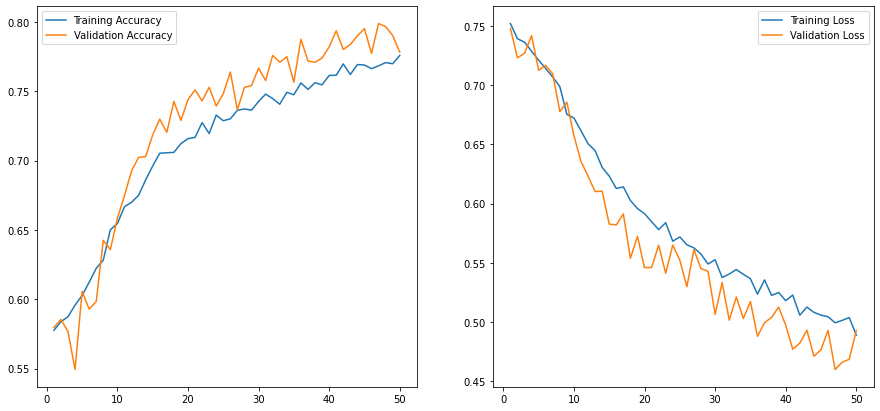

In [51]:
fig, axes = plt.subplots(1,2, figsize=(15,7))
epoch_list = list(range(1, len(hist.history['accuracy']) + 1))
axes[0].plot(epoch_list, hist.history['accuracy'], epoch_list, hist.history['val_accuracy'])
axes[0].legend(('Training Accuracy', 'Validation Accuracy'))
axes[1].plot(epoch_list, hist.history['loss'], epoch_list, hist.history['val_loss'])
axes[1].legend(('Training Loss', 'Validation Loss'))
plt.show()

In [52]:
model_structure = model.to_json()
f = Path("models/Deep_0852.json")
f.write_text(model_structure)

model.save_weights("models/Deep_0852.h5")

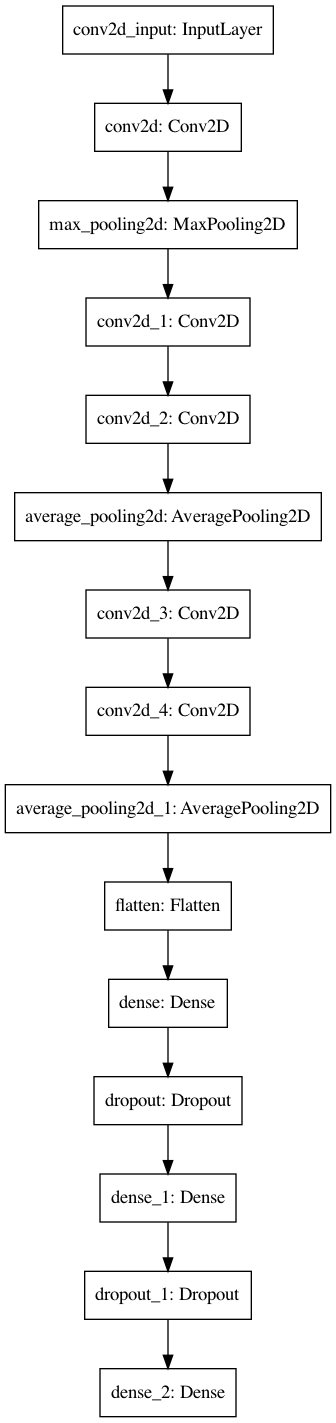

In [5]:
from keras.utils import plot_model
plot_model(model, to_file="model.png")